In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, train_test_split,cross_validate
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import seaborn as sns

In [47]:
def rmseByDepth(y_test,y_pred,h = 2.5,delta = 2.5,jump = 5,maxh = 110):

    hList = []
    rmseList = []
    df = pd.DataFrame()

    while h < maxh:
        hList.append(h)
        idx = np.where((y_test >= h - delta) & (y_test < h + delta))
        rmse = mse(y_test[idx],y_pred[idx],squared = False)
        rmseList.append(rmse)        
        h = h + jump
    
    df['h'] = hList
    df['rmse'] = rmseList
    
    return df

In [2]:
data_A = pd.read_csv("C:/Users/Dave Mont/Desktop/Master_of_DataScience/TFM/Results/depth_estimation/train-test-val/data_AL.csv")
data_B = pd.read_csv("C:/Users/Dave Mont/Desktop/Master_of_DataScience/TFM/Results/depth_estimation/train-test-val/data_B.csv")
data_C = pd.read_csv("C:/Users/Dave Mont/Desktop/Master_of_DataScience/TFM/Results/depth_estimation/train-test-val/data_C.csv")
data_G = pd.read_csv("C:/Users/Dave Mont/Desktop/Master_of_DataScience/TFM/Results/depth_estimation/train-test-val/data_G.csv")

In [67]:
X_A = data_A.iloc[:,3:]
y_A = data_A.iloc[:,0]

X_B = data_B.iloc[:,3:]
y_B = data_B.iloc[:,0]

X_C = data_C.iloc[:,3:]
y_C = data_C.iloc[:,0]

X_G = data_G.iloc[:,3:]
y_G = data_G.iloc[:,0]

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A,y_A,test_size = 0.05,random_state = 20)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B,y_B,test_size = 0.05,random_state = 20)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C,y_C,test_size = 0.05,random_state = 20)
X_train_G, X_test_G, y_train_G, y_test_G = train_test_split(X_G,y_G,test_size = 0.05,random_state = 20)

In [68]:
X_train = pd.concat([X_train_A,X_train_B,X_train_C,X_train_G])
y_train = pd.concat([y_train_A,y_train_B,y_train_C,y_train_G])
y_test = np.array(pd.concat([y_test_A,y_test_B,y_test_C,y_test_G]))

In [69]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Linear Regression (LR)

In [127]:
cv_results = pd.DataFrame(cross_validate(LinearRegression(),X_train,y_train,cv = 10,scoring = ["neg_root_mean_squared_error","r2"]))
cv_results['test_neg_root_mean_squared_error'] = cv_results['test_neg_root_mean_squared_error']*-1

In [128]:
rmse_mean = cv_results['test_neg_root_mean_squared_error'].mean()
rmse_std = cv_results['test_neg_root_mean_squared_error'].std()
print("RMSE: %0.3f +/- %0.3f" % (rmse_mean,rmse_std/np.sqrt(10)))

RMSE: 14.810 +/- 1.294


In [129]:
reg = LinearRegression().fit(X_train,y_train)

In [130]:
y_pred_A = reg.predict(scaler.transform(X_test_A))
y_pred_B = reg.predict(scaler.transform(X_test_B))
y_pred_C = reg.predict(scaler.transform(X_test_C))
y_pred_G = reg.predict(scaler.transform(X_test_G))

In [131]:
print("Alto-Lindoso = R2: %0.2f, RMSE %0.3f" % (r2(y_test_A,y_pred_A),mse(y_test_A,y_pred_A,squared = False)))
print("Bubal = R2: %0.2f, RMSE %0.3f" % (r2(y_test_B,y_pred_B),mse(y_test_B,y_pred_B,squared = False)))
print("Canelles = R2: %0.2f, RMSE %0.3f" % (r2(y_test_C,y_pred_C),mse(y_test_C,y_pred_C,squared = False)))
print("Grado = R2: %0.2f, RMSE %0.3f" % (r2(y_test_G,y_pred_G),mse(y_test_G,y_pred_G,squared = False)))

Alto-Lindoso = R2: 0.53, RMSE 10.269
Bubal = R2: 0.04, RMSE 9.245
Canelles = R2: 0.55, RMSE 19.061
Grado = R2: 0.53, RMSE 10.656


In [132]:
y_pred = np.concatenate((y_pred_A,y_pred_B,y_pred_C,y_pred_G))

In [133]:
print("Total = R2: %0.2f, RMSE %0.3f" % (r2(y_test,y_pred),mse(y_test,y_pred,squared = False)))

Total = R2: 0.60, RMSE 15.170


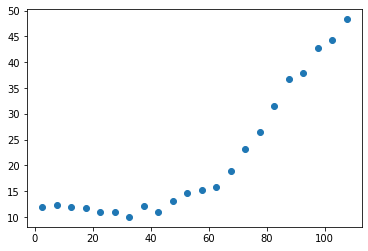

In [135]:
rmseDepth = rmseByDepth(y_test,y_pred)
rmseDepth.to_csv("C:/Users/Dave Mont/Desktop/Master_of_DataScience/TFM/Results/depth_estimation/test-results/depth-rmse-LR.csv",index = False)
plt.scatter(rmseDepth['h'],rmseDepth['rmse'])

# Random Forest (RF)

In [144]:
randomRF = rf(n_estimators = 3,max_features = "auto",verbose = 1)
randomRF.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.4s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=3, n_jobs=None, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

In [139]:
parameters = {"n_estimators":np.round(np.logspace(0,3,10)).astype('int'),"max_features":["auto","sqrt","log2"]}
rfReg = GridSearchCV(rf(),parameters,cv = 10,scoring = "neg_root_mean_squared_error")
rfReg.fit(X_train,y_train)

KeyboardInterrupt: 

In [175]:
bestRF = rfReg.best_estimator_

In [176]:
y_pred_A = bestRF.predict(scaler.transform(X_test_A))
y_pred_B = bestRF.predict(scaler.transform(X_test_B))
y_pred_C = bestRF.predict(scaler.transform(X_test_C))
y_pred_G = bestRF.predict(scaler.transform(X_test_G))

In [177]:
print("Alto-Lindoso = R2: %0.2f, RMSE %0.3f" % (r2(y_test_A,y_pred_A),mse(y_test_A,y_pred_A,squared = False)))
print("Bubal = R2: %0.2f, RMSE %0.3f" % (r2(y_test_B,y_pred_B),mse(y_test_B,y_pred_B,squared = False)))
print("Canelles = R2: %0.2f, RMSE %0.3f" % (r2(y_test_C,y_pred_C),mse(y_test_C,y_pred_C,squared = False)))
print("Grado = R2: %0.2f, RMSE %0.3f" % (r2(y_test_G,y_pred_G),mse(y_test_G,y_pred_G,squared = False)))

Alto-Lindoso = R2: 0.66, RMSE 8.756
Bubal = R2: 0.81, RMSE 4.063
Canelles = R2: 0.74, RMSE 14.427
Grado = R2: 0.90, RMSE 4.983


In [178]:
y_test = np.array(pd.concat([y_test_A,y_test_B,y_test_C,y_test_G]))
y_pred = np.concatenate((y_pred_A,y_pred_B,y_pred_C,y_pred_G))

In [179]:
print("Total = R2: %0.2f, RMSE %0.3f" % (r2(y_test,y_pred),mse(y_test,y_pred,squared = False)))

Total = R2: 0.79, RMSE 10.953


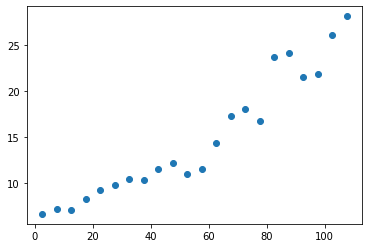

In [180]:
h = 2.5
delta = 2.5
jump = 5

hList = []
rmseList = []

while h < 110:
    hList.append(h)
    idx = np.where((y_test > h - delta) & (y_test < h + delta))
    rmse = mse(y_test[idx],y_pred[idx],squared = False)
    rmseList.append(rmse)
    #print("[%0.0f-%0.0f]: RMSE %0.3f" % (h - delta,h + delta,rmse))
    h = h + jump

plt.scatter(hList,rmseList)